In [1]:
#Loading the required packages
import numpy as np   
from sklearn.linear_model import LinearRegression
from scipy import stats 
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd    
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
#Loading the json file and concatinating it with car names
ca=pd.read_json (r'./car.json')
ca1=pd.read_csv('./Car name.csv')
car=pd.concat([ca,ca1],axis=1)
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
row, column = car.shape
print('The dataset contains', row, 'rows and', column, 'columns')


The dataset contains 398 rows and 9 columns


In [4]:
# save this data as to csv,xlsx and json
car.to_csv('mpg.csv', index=False)
car.to_excel('mpg.xlsx', index = False)
car.to_json('mpg.json', orient = 'split', compression = 'infer', index = 'true')

In [5]:
#dropping/ignoring car_name 
car = car.drop('car_name', axis=1)
# Also replacing the categorical var with actual values
car['origin'] = car['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130,3504,12.0,70,america
1,15.0,8,350.0,165,3693,11.5,70,america
2,18.0,8,318.0,150,3436,11.0,70,america
3,16.0,8,304.0,150,3433,12.0,70,america
4,17.0,8,302.0,140,3449,10.5,70,america


In [6]:
print('The data type of each attribute: \n')
car.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
 1   cyl     398 non-null    int64  
 2   disp    398 non-null    float64
 3   hp      398 non-null    object 
 4   wt      398 non-null    int64  
 5   acc     398 non-null    float64
 6   yr      398 non-null    int64  
 7   origin  398 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [7]:
#5-point summary
car.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


In [8]:
# isdigit()? on 'horsepower' 
hpIsDigit = pd.DataFrame(car.hp.str.isdigit()) 

#print isDigit = False!
car[hpIsDigit['hp'] == False]  

,mpg,cyl,disp,hp,wt,acc,yr,origin
32,25.0,4,98.0,?,2046,19.0,71,america
126,21.0,6,200.0,?,2875,17.0,74,america
330,40.9,4,85.0,?,1835,17.3,80,europe
336,23.6,4,140.0,?,2905,14.3,80,america
354,34.5,4,100.0,?,2320,15.8,81,europe
374,23.0,4,151.0,?,3035,20.5,82,america


In [9]:
# Replace missing values with NaN
car = car.replace('?', np.nan)
car[hpIsDigit['hp'] == False] 

,mpg,cyl,disp,hp,wt,acc,yr,origin
32,25.0,4,98.0,NaN,2046,19.0,71,america
126,21.0,6,200.0,NaN,2875,17.0,74,america
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,america
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,america


In [10]:
#replace hp with median
car['hp'].fillna((car['hp'].median()), inplace=True)

In [11]:
print('The data set has no missing values \n')
car.isnull().sum()

The data set has no missing values 



mpg       0
cyl       0
disp      0
hp        0
wt        0
acc       0
yr        0
origin    0
dtype: int64

In [12]:
#creating mpg_level attribute using the 25% and 75% of mpg values( <  17 as low, > 17 and <29 as medium, > 29 as high  )
car['mpg_level'] = car['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,mpg_level
0,18.0,8,307.0,130.0,3504,12.0,70,america,medium
1,15.0,8,350.0,165.0,3693,11.5,70,america,low
2,18.0,8,318.0,150.0,3436,11.0,70,america,medium
3,16.0,8,304.0,150.0,3433,12.0,70,america,low
4,17.0,8,302.0,140.0,3449,10.5,70,america,medium


In [13]:
#categorical variable
car_cat = car.iloc[:,[1,6,7,8]]
car_cat.head()

,cyl,yr,origin,mpg_level
0,8,70,america,medium
1,8,70,america,low
2,8,70,america,medium
3,8,70,america,low
4,8,70,america,medium


In [14]:
#numeric variables
car_num=car.drop(['cyl','yr','origin','mpg_level'],axis=1)
car_num.head()


,mpg,disp,hp,wt,acc
0,18.0,307.0,130.0,3504,12.0
1,15.0,350.0,165.0,3693,11.5
2,18.0,318.0,150.0,3436,11.0
3,16.0,304.0,150.0,3433,12.0
4,17.0,302.0,140.0,3449,10.5


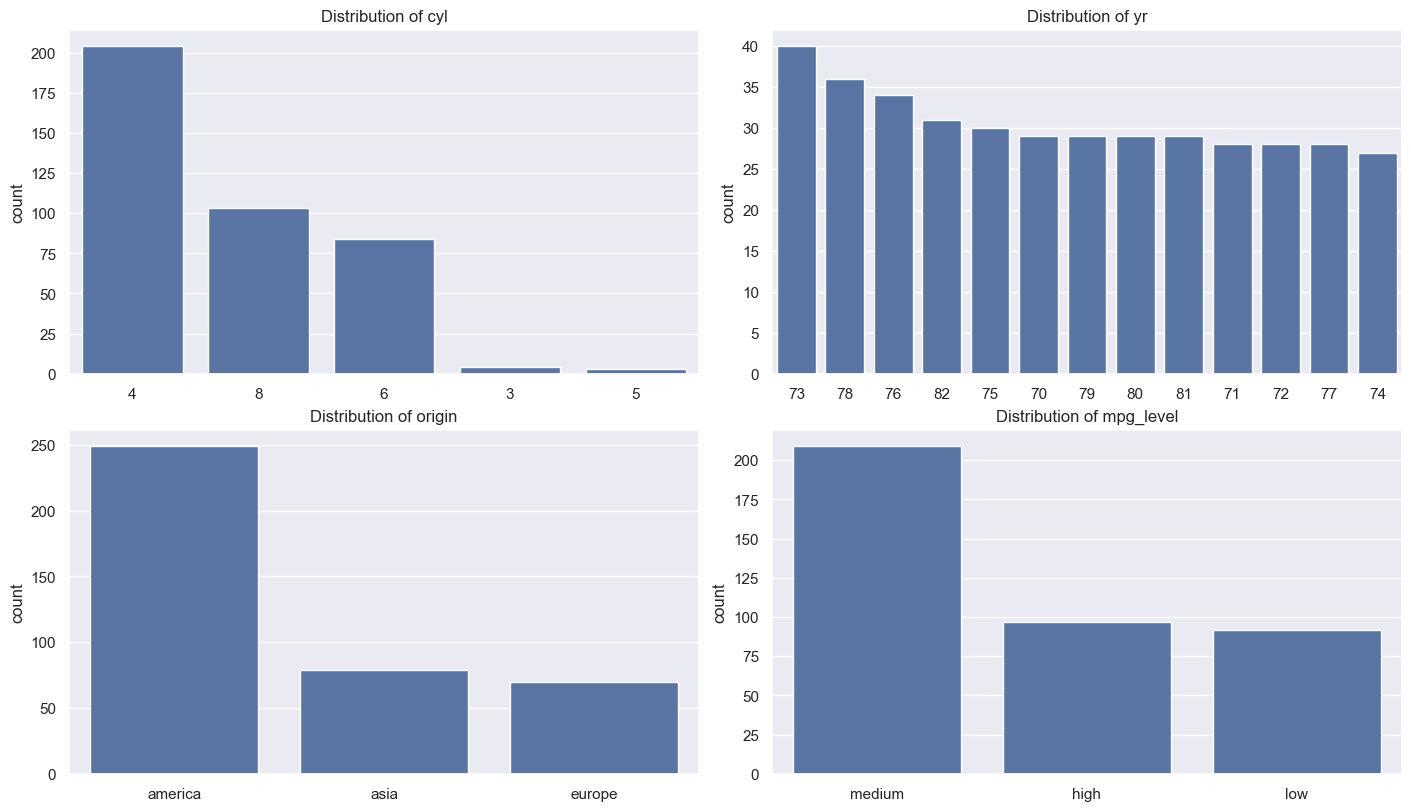

In [15]:
# Number of categorical columns
num_vars = len(car_cat.columns)

# Determine number of rows and columns for subplots
num_rows = (num_vars + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, car in enumerate(car_cat.columns):
    ax = axes[i]
    sns.countplot(x=car_cat[car], order=car_cat[car].value_counts().index, ax=ax)
    
    # Calculate counts and percentages
    counts = car_cat[car].value_counts()
    percentages = counts / counts.sum() * 100
    

    
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

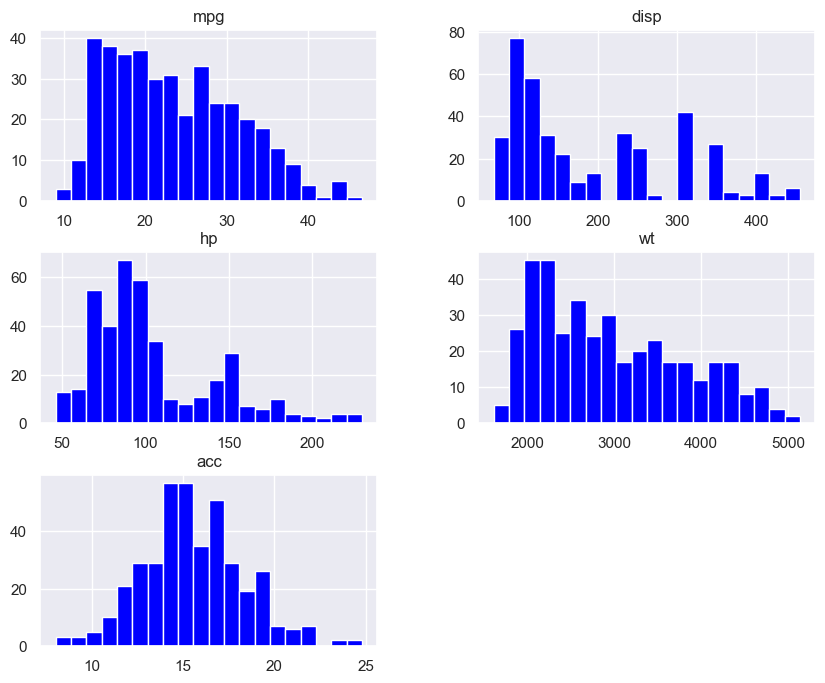

In [16]:
#plot histograms
car_num.hist(bins = 20, figsize = (10, 8), color = 'blue')
plt.show()

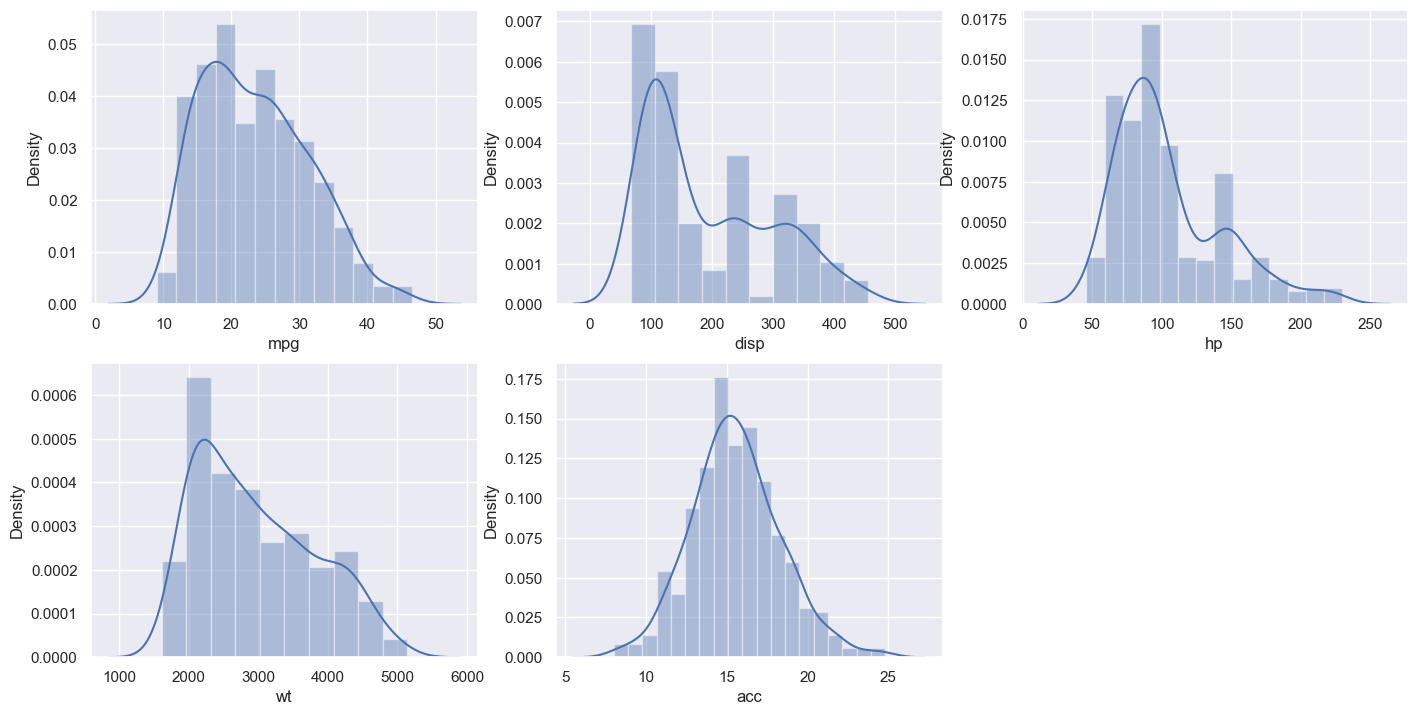

In [17]:
#plot density
plt.figure(figsize=(17, 13))
col = 1
for i in car_num.columns:
    plt.subplot(3, 3, col)
    sns.distplot(car_num[i], color = 'b')
    col += 1 

In [18]:
#joining the categorical and numerical variables
car=pd.concat([car_cat,car_num],axis=1)
#checking for attribute type
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cyl        398 non-null    int64  
 1   yr         398 non-null    int64  
 2   origin     398 non-null    object 
 3   mpg_level  398 non-null    object 
 4   mpg        398 non-null    float64
 5   disp       398 non-null    float64
 6   hp         398 non-null    float64
 7   wt         398 non-null    int64  
 8   acc        398 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


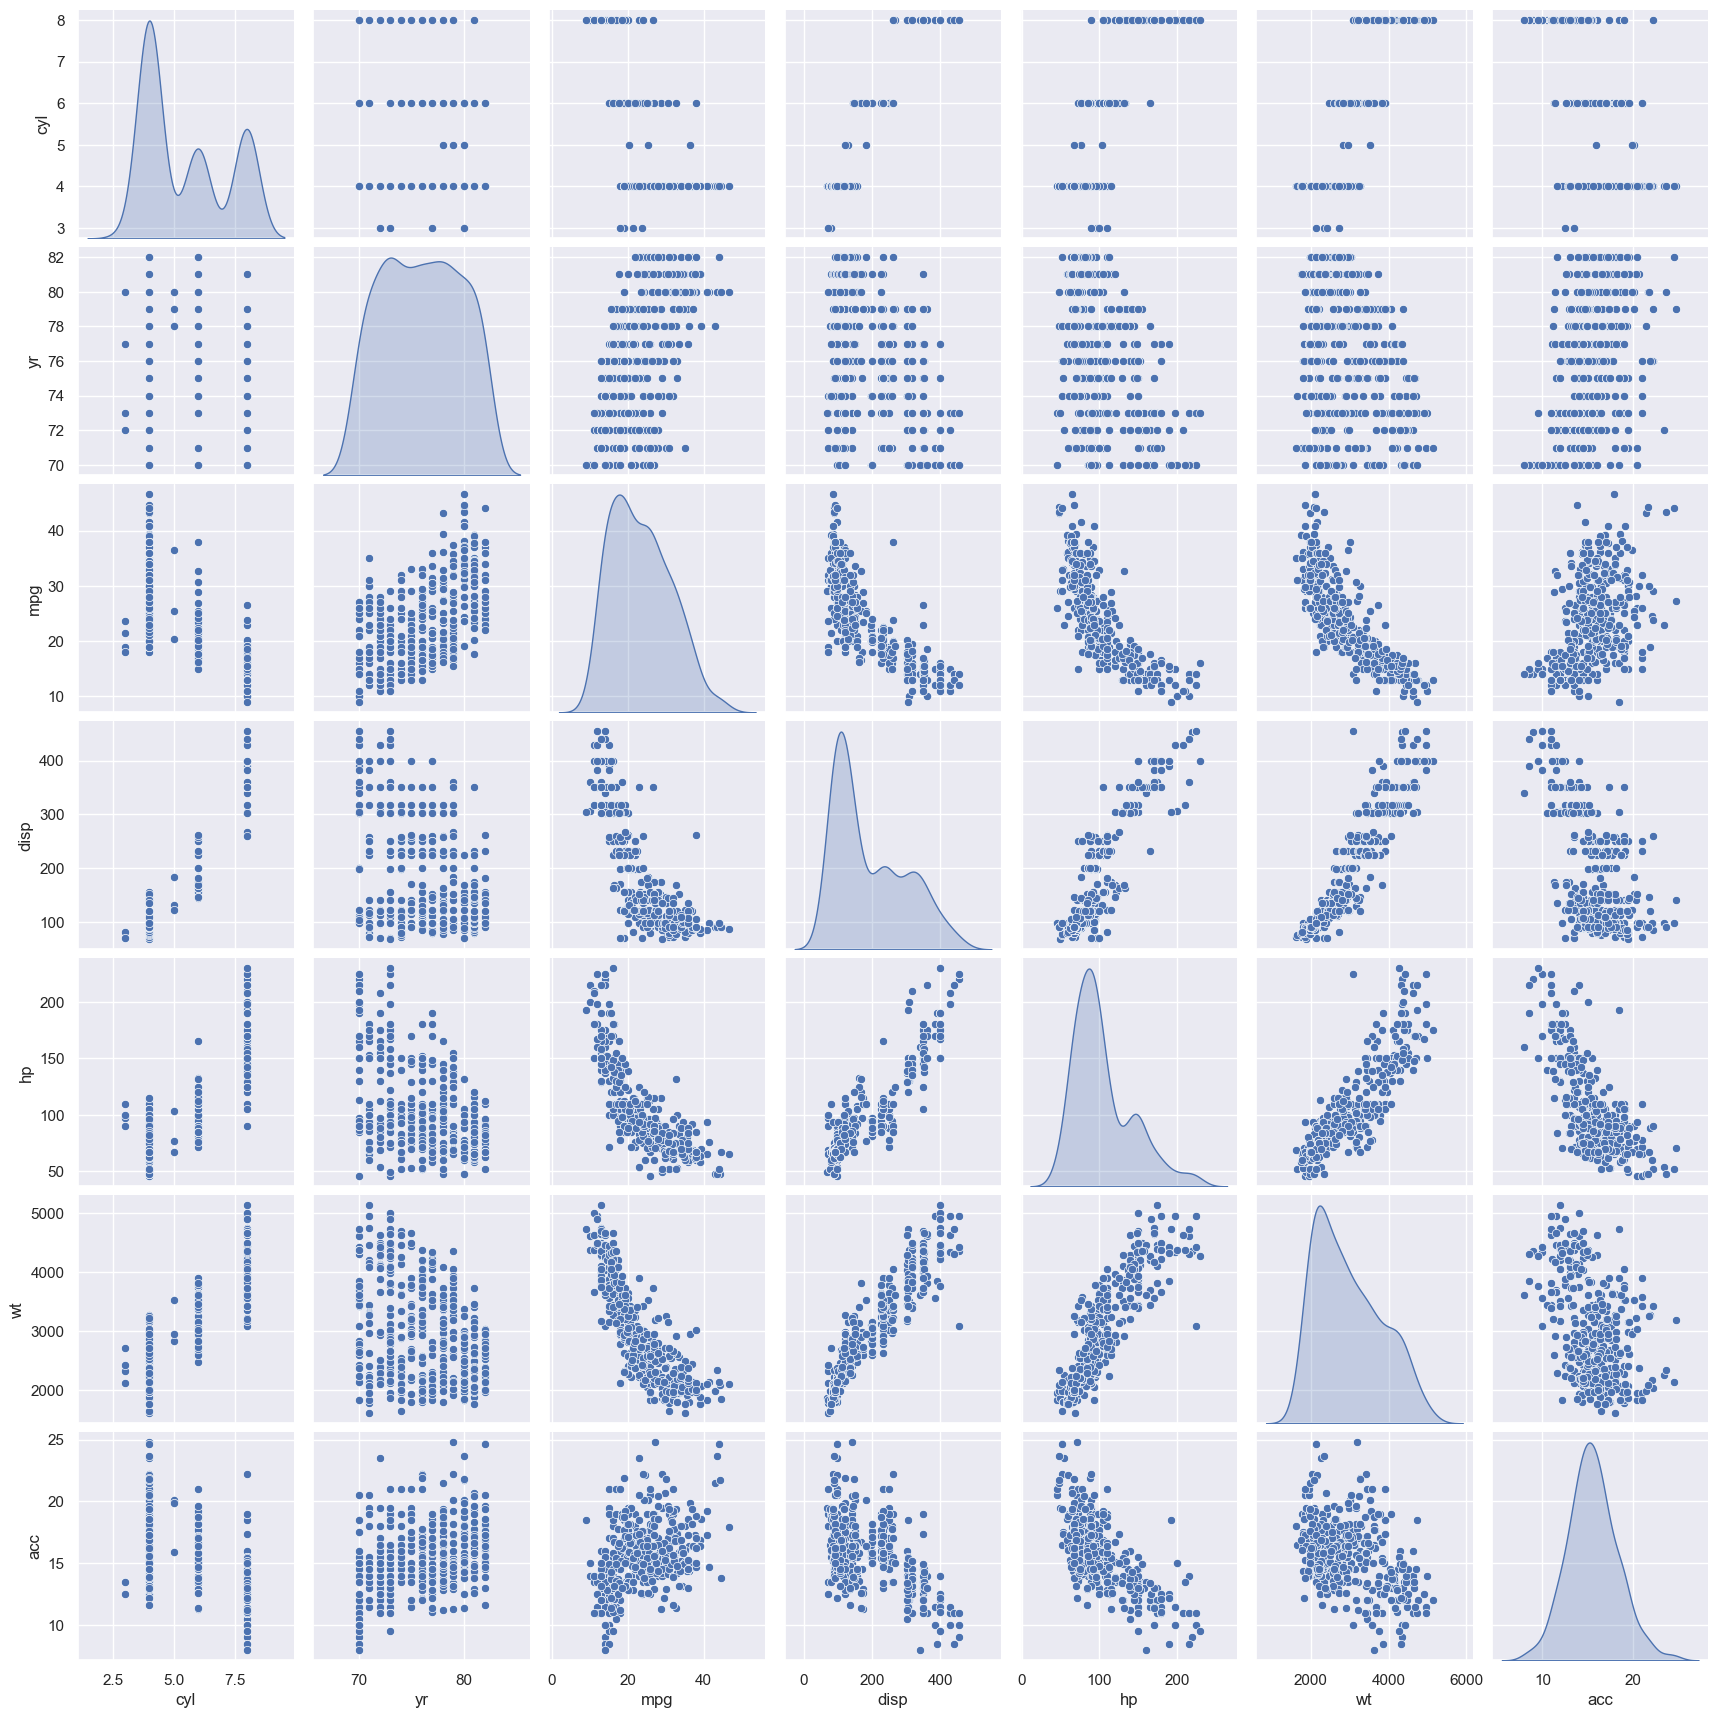

In [19]:
#create dummy varibale for mpg_level and origin and creating a seperate datset for k-means and heirarchical clustering
car = pd.get_dummies(car, columns=['origin'])
car = pd.get_dummies(car, columns=['mpg_level'])
car.head()
carH=car.copy()
carK=car.copy()
#pair plot for the numeric attributes
car_attr = car.iloc[:, 0:7]
sns.pairplot(car_attr, diag_kind='kde')

In [20]:
#dropping the created dummy variable
car2=car.drop(['origin_america','origin_asia','origin_europe','mpg_level_high','mpg_level_low','mpg_level_medium'],axis=1)

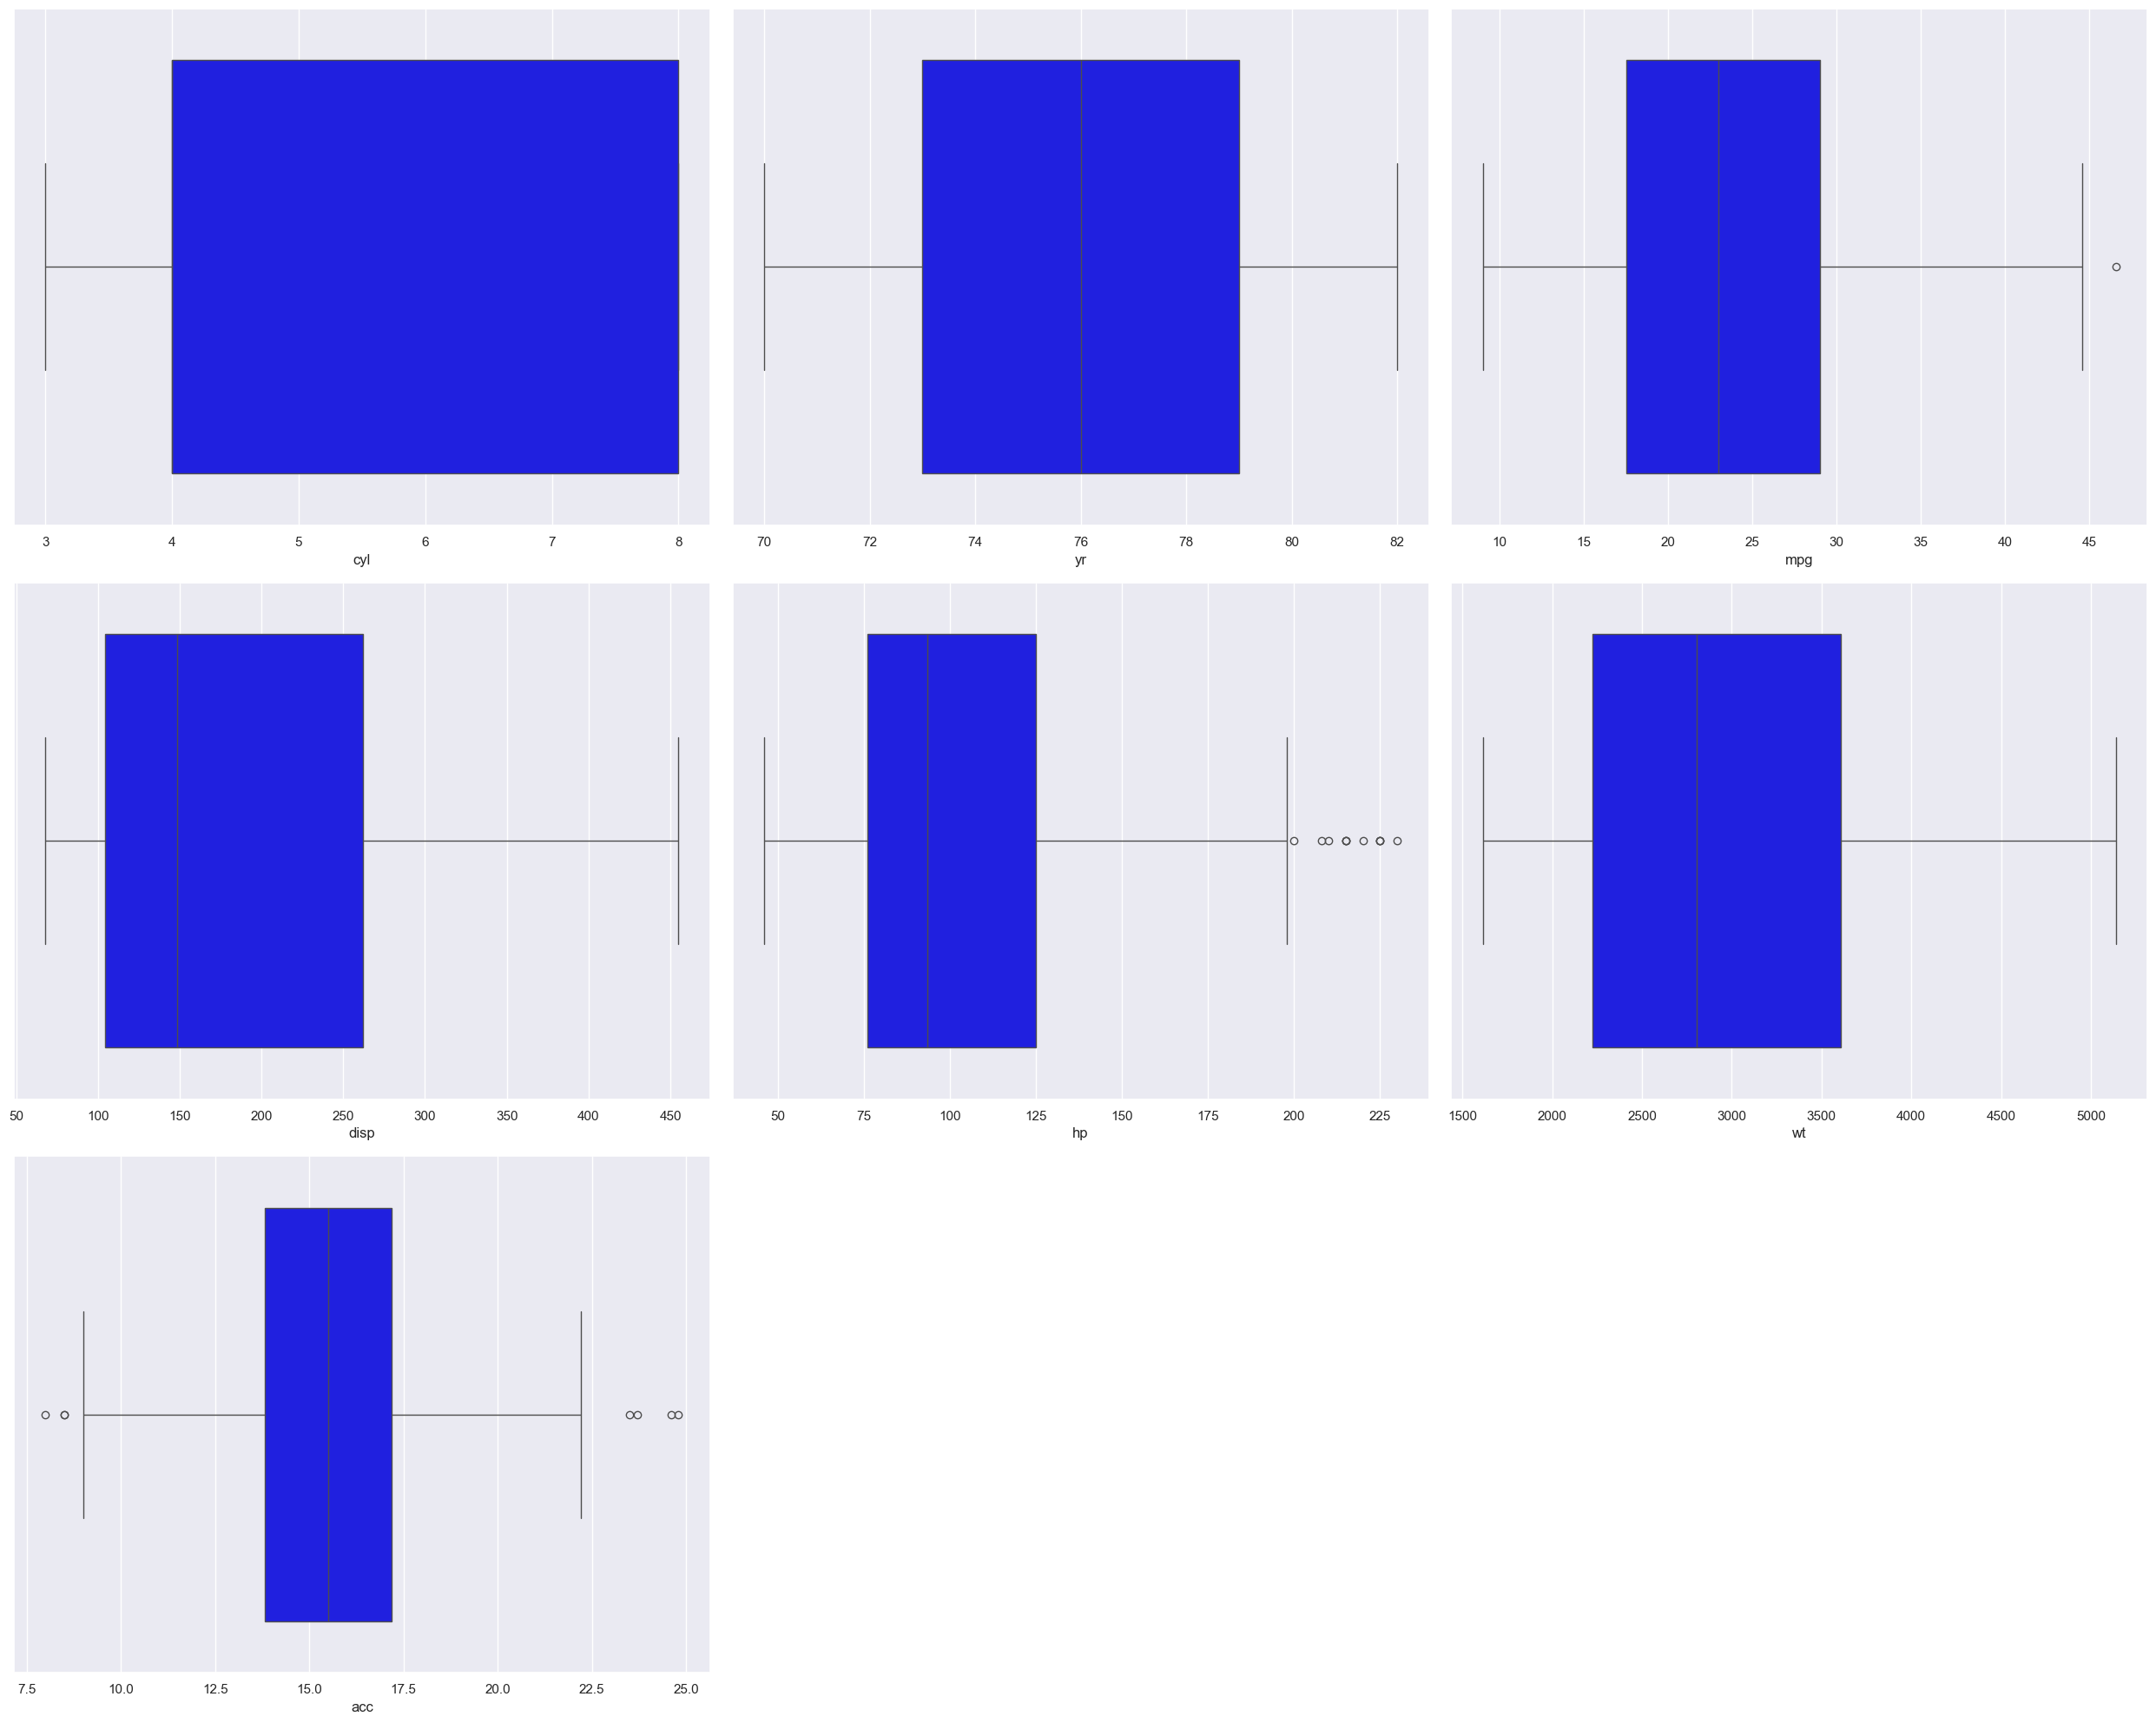

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 20))
col = 1
for i in car2.columns:
    plt.subplot(3, 3, col)
    sns.boxplot(x=car2[i], color='blue', orient='h')
    col += 1

plt.tight_layout()
plt.show()


In [22]:
#replacing outliers with IQR (Q1 and Q3 +-1.5*IQR)
IQR1 = stats.iqr(car2['hp'], interpolation = 'midpoint')
IQR2 = stats.iqr(car2['acc'], interpolation = 'midpoint')

<Axes: xlabel='hp'>

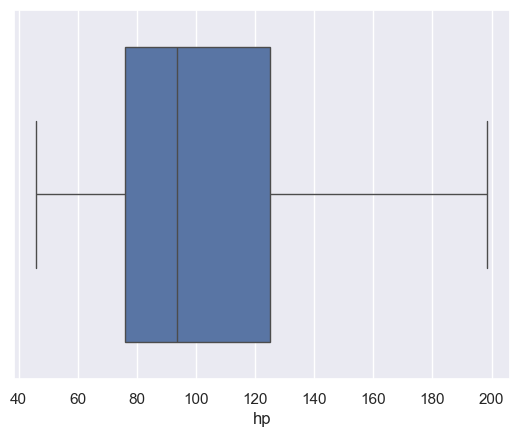

In [23]:
#Horsepower after imputing outliers
Q3 = car2['hp'].quantile(0.75)
car2['hp'] = np.where(car2["hp"] >(Q3+1.5*IQR1), 198.5,car2['hp'])
sns.boxplot(car2['hp'],orient='h')

<Axes: xlabel='acc'>

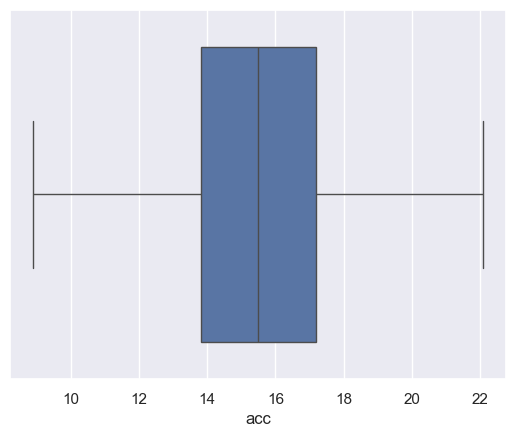

In [24]:
#accelaration after imputing outliers
Q1 = car2['acc'].quantile(0.25)
Q31=car2['acc'].quantile(0.75)
car2['acc'] = np.where(car2["acc"] >(Q31+1.5*IQR2),22.10 ,car2['acc'])
car2['acc'] = np.where(car2["acc"] <(Q1-1.5*IQR2),(Q1-1.5*IQR2),car2['acc'])
sns.boxplot(car2['acc'],orient='h')

<Axes: >

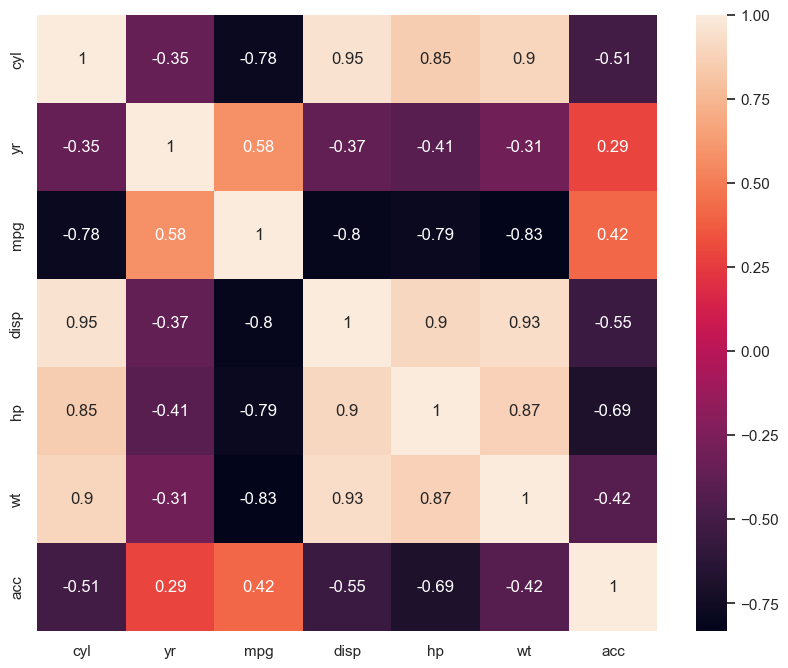

In [25]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=car2.corr()
sns.heatmap(corr,annot=True)


# Heirarchical Clustering

In [26]:
#separating numeric variables
cc = car.iloc[:,0:7] 
cc.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,8,70,18.0,307.0,130.0,3504,12.0
1,8,70,15.0,350.0,165.0,3693,11.5
2,8,70,18.0,318.0,150.0,3436,11.0
3,8,70,16.0,304.0,150.0,3433,12.0
4,8,70,17.0,302.0,140.0,3449,10.5


In [27]:
#scaling the variable
cc_z = cc.apply(zscore)
cc_z.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117


In [28]:
#calculating pairwise distance using average linkage method
link_method = linkage(cc_z.iloc[:,0:7], method = 'average')

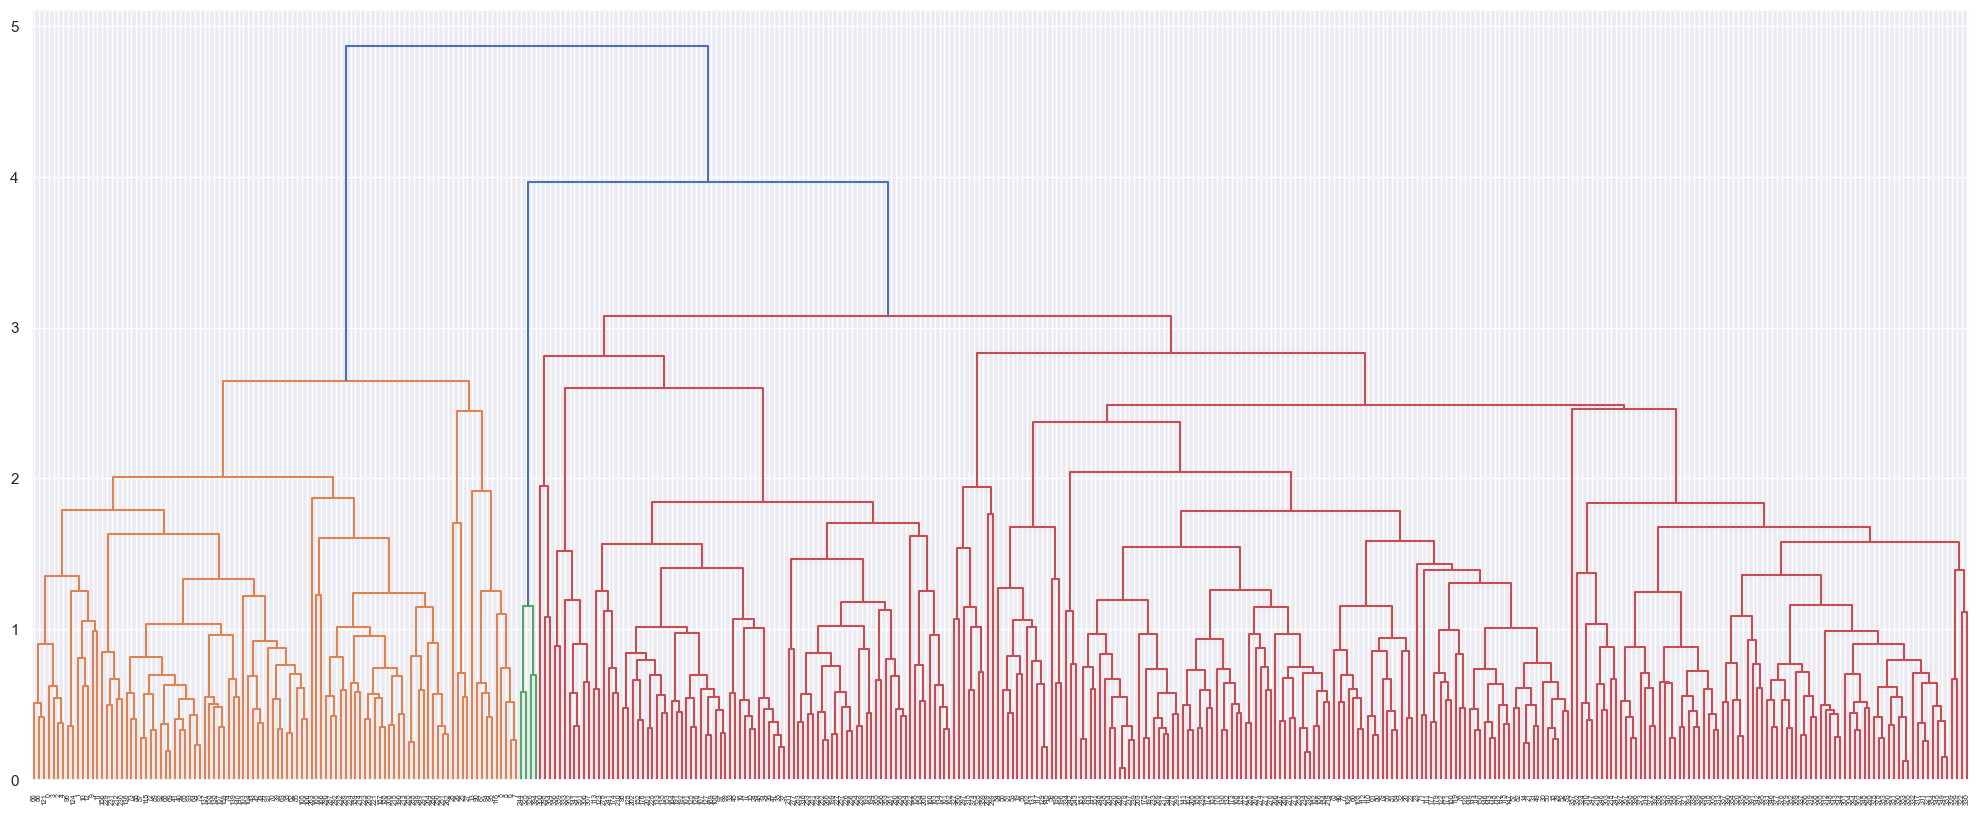

In [29]:
#plotting the H-cluster
plt.figure(figsize=(25, 10))
dendrogram(link_method)
plt.show()

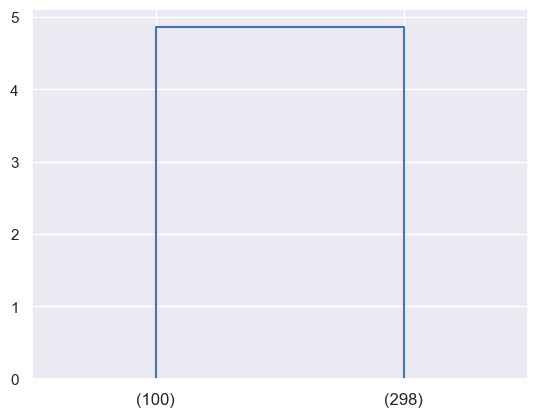

In [30]:
# dendrogram function to arrive at dendrogram
dendrogram(
    link_method,
    truncate_mode='lastp',  
    p=2,  
)
plt.show()

In [31]:
#vieweing the clusters formed
clusters = fcluster(link_method, 2, criterion='maxclust')
print(clusters)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 2 2 2 2
 2 2 2 2 1 1 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1 1 1 2 2 2 2 2 1
 2 1 1 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [32]:
#attaching the clusters formed to the scales data
cc_z['clusters_H'] = clusters
cc_z.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498,1
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038,1
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577,1
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498,1
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117,1


In [33]:
#vieweing the distribution of clusters
cc_z.clusters_H.value_counts().sort_index()

clusters_H
1    100
2    298
Name: count, dtype: int64

In [34]:
#attaching the clusters formed to the original data
cc['clusters_H']=clusters
carH['clusters_H']=clusters
cc.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,8,70,18.0,307.0,130.0,3504,12.0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1
2,8,70,18.0,318.0,150.0,3436,11.0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1


In [35]:
#create a new data set named Hclus
Hclus=cc
Hclus.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,8,70,18.0,307.0,130.0,3504,12.0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1
2,8,70,18.0,318.0,150.0,3436,11.0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1


In [36]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('clusters_H').mean()
aggdata['Freq']=cc.clusters_H.value_counts().sort_index()
aggdata

,cyl,yr,mpg,disp,hp,wt,acc,Freq
clusters_H,,,,,,,,
1,7.980000,73.740000,14.684000,345.470000,160.400000,4121.560000,12.702000,100
2,4.607383,76.771812,26.477852,142.404362,85.479866,2584.137584,16.529866,298


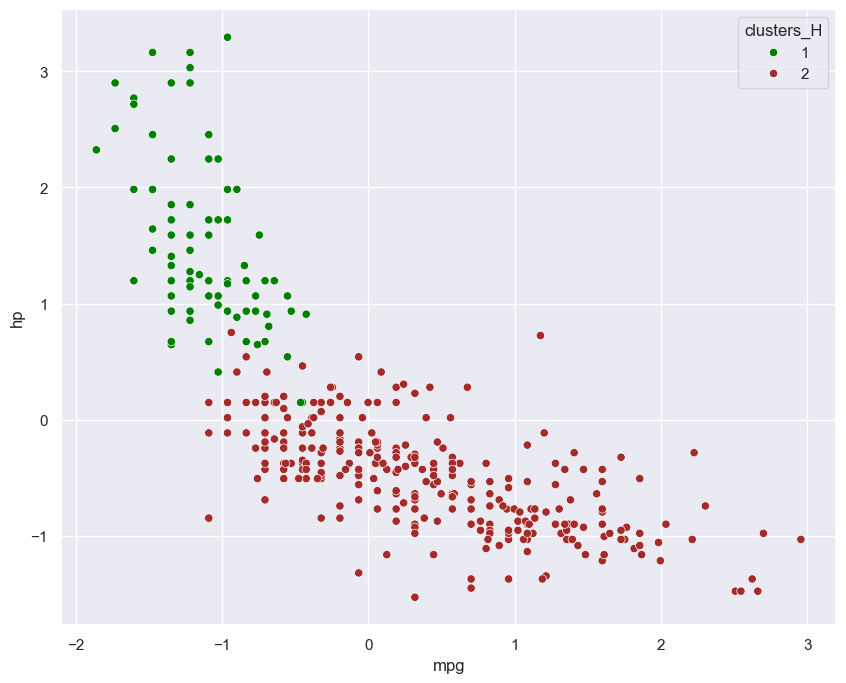

In [37]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="clusters_H",
              data=cc_z, 
                    palette=['green','brown']);

# K-Means Clustering

In [38]:
#seperating the numeric values
cc = car.iloc[:,0:7] 
cc_z1 = cc.apply(zscore)
cc_z1.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117


In [39]:
#calculatint the within sum of squares
wss =[] 
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(cc_z1)
    wss.append(KM.inertia_)
wss

[2785.999999999999, 1295.122935262958, 946.0197908553791, 738.3923281527312]

Text(0, 0.5, 'WSS')

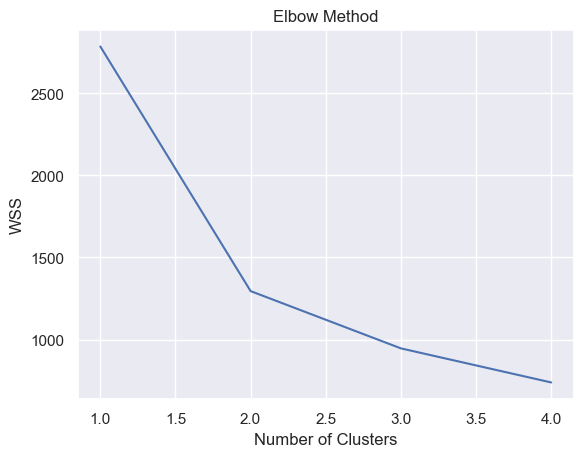

In [40]:
#plotting the WSS against the number of cluster to come up with optimal number of clusters using Elbow-method
plt.plot(range(1,5), wss)
plt.title('Elbow Method')
plt.xlabel("Number of Clusters")
plt.ylabel("WSS")

In [41]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(cc_z1)
labels = k_means.labels_

In [42]:
# Calculating silhouette_score
silhouette_score(cc_z1,labels)

0.46264452576184095

In [43]:
#calculating silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}


silhouette_coefficients = []

 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc_z1)
    score = silhouette_score(cc_z1,kmeans.labels_)
    silhouette_coefficients.append(score)

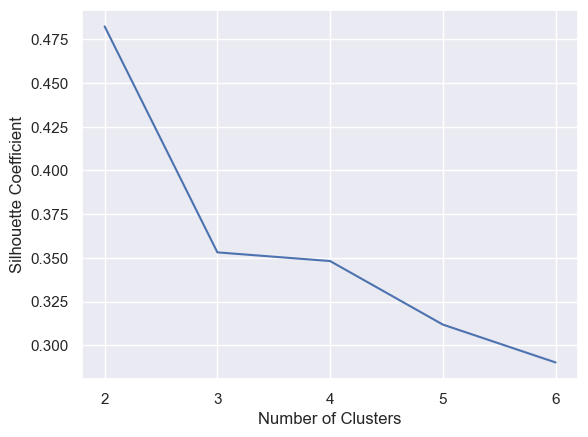

In [44]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [45]:
#attaching the labels to the datasets
cc["cluster_K"] = labels
carK['cluster_K']=labels
Kclus=cc
Kclus.head()

,cyl,yr,mpg,disp,hp,wt,acc,cluster_K
0,8,70,18.0,307.0,130.0,3504,12.0,0
1,8,70,15.0,350.0,165.0,3693,11.5,0
2,8,70,18.0,318.0,150.0,3436,11.0,0
3,8,70,16.0,304.0,150.0,3433,12.0,0
4,8,70,17.0,302.0,140.0,3449,10.5,0


In [46]:
#vieweing the distribution of clusters
cc.cluster_K.value_counts().sort_index()

cluster_K
0    122
1    276
Name: count, dtype: int64

In [47]:
#attaching the clsuters to the scaled data
cc_z1["cluster_K"] = labels
cc_z1.head()

,cyl,yr,mpg,disp,hp,wt,acc,cluster_K
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498,0
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038,0
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577,0
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498,0
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117,0


In [48]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('cluster_K').mean()
aggdata['Freq']=cc.cluster_K.value_counts().sort_index()
aggdata

,cyl,yr,mpg,disp,hp,wt,acc,Freq
cluster_K,,,,,,,,
0,7.672131,73.827869,15.275410,328.860656,150.540984,4008.680328,13.360656,122
1,4.474638,76.974638,27.156522,133.559783,83.865942,2511.485507,16.543841,276


<Axes: xlabel='mpg', ylabel='hp'>

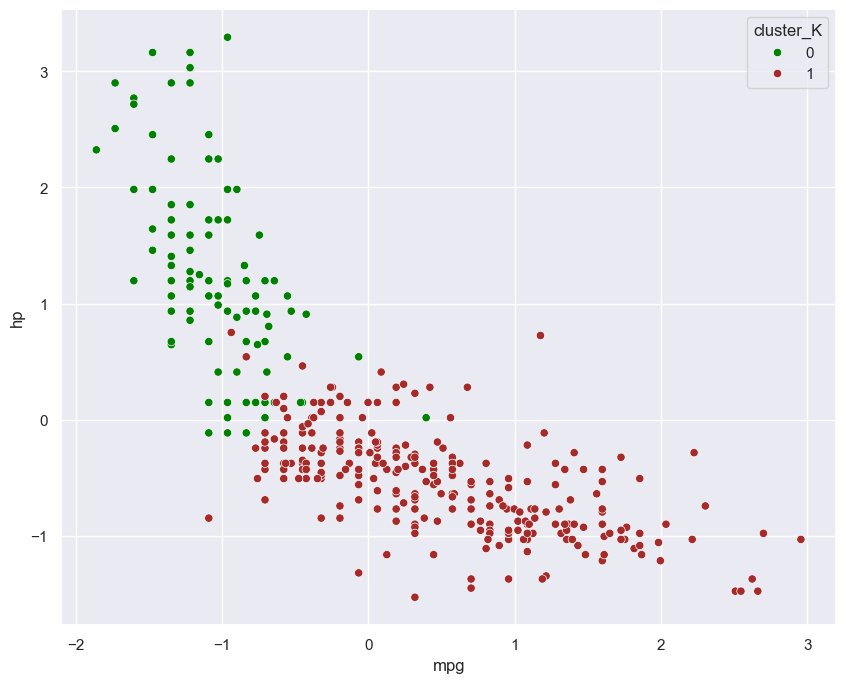

In [49]:
#plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="cluster_K",
              data=cc_z1, 
                    palette=['green','brown'])

In [50]:
carH.clusters_H.value_counts().sort_index()

clusters_H
1    100
2    298
Name: count, dtype: int64

In [51]:
carK.cluster_K.value_counts().sort_index()

cluster_K
0    122
1    276
Name: count, dtype: int64

In [52]:
carH.shape

(398, 14)

In [53]:
carK.shape

(398, 14)

In [54]:
car.head()

,cyl,yr,mpg,disp,hp,wt,acc,origin_america,origin_asia,origin_europe,mpg_level_high,mpg_level_low,mpg_level_medium
0,8,70,18.0,307.0,130.0,3504,12.0,True,False,False,False,False,True
1,8,70,15.0,350.0,165.0,3693,11.5,True,False,False,False,True,False
2,8,70,18.0,318.0,150.0,3436,11.0,True,False,False,False,False,True
3,8,70,16.0,304.0,150.0,3433,12.0,True,False,False,False,True,False
4,8,70,17.0,302.0,140.0,3449,10.5,True,False,False,False,False,True


# Linear regression on the original dataset

In [55]:
X = car.drop(['mpg','origin_europe','mpg_level_low'], axis=1)
# the dependent variable
y = car[['mpg']]

In [56]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [57]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [58]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.51344413862189
The coefficient for yr is 0.44346504291168587
The coefficient for disp is 0.010688858394647031
The coefficient for hp is 0.010315514536314081
The coefficient for wt is -0.0045387885687371765
The coefficient for acc is 0.19183425608862587
The coefficient for origin_america is -1.730620951368903
The coefficient for origin_asia is -0.8976724344009387
The coefficient for mpg_level_high is 8.552374663817021
The coefficient for mpg_level_medium is 1.5941218694850436


In [59]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1.6635717568651955


In [60]:
regression_model.score(X_train, y_train)

0.8967703023839787

In [61]:
O=regression_model.score(X_test, y_test)

# Linear regression on data with K means cluster

In [62]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
carK['cluster_K']=carK['cluster_K'].astype('category')
carK['cluster_K'] = carK['cluster_K'].replace({1: 'heavy', 0: 'light'})
carK = pd.get_dummies(carK, columns=['cluster_K'])

In [63]:
carK.head()

,cyl,yr,mpg,disp,hp,wt,acc,origin_america,origin_asia,origin_europe,mpg_level_high,mpg_level_low,mpg_level_medium,cluster_K_light,cluster_K_heavy
0,8,70,18.0,307.0,130.0,3504,12.0,True,False,False,False,False,True,True,False
1,8,70,15.0,350.0,165.0,3693,11.5,True,False,False,False,True,False,True,False
2,8,70,18.0,318.0,150.0,3436,11.0,True,False,False,False,False,True,True,False
3,8,70,16.0,304.0,150.0,3433,12.0,True,False,False,False,True,False,True,False
4,8,70,17.0,302.0,140.0,3449,10.5,True,False,False,False,False,True,True,False


In [64]:
X = carK.drop(['mpg','origin_europe','mpg_level_low','cluster_K_light'], axis=1)
# the dependent variable
y = carK[['mpg']]

In [65]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

In [66]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [67]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.9294768073695783
The coefficient for yr is 0.4352088509076378
The coefficient for disp is 0.015813994372745874
The coefficient for hp is -0.0008337744696468655
The coefficient for wt is -0.00426297559641417
The coefficient for acc is 0.17355926802713328
The coefficient for origin_america is -1.7298134686895639
The coefficient for origin_asia is -0.8199355878362724
The coefficient for mpg_level_high is 9.301610983226002
The coefficient for mpg_level_medium is 2.111345743565729
The coefficient for cluster_K_heavy is -1.1870149691619074


In [68]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))


The intercept for our model is 1.2087939827466023


In [69]:
regression_model.score(X_train, y_train)

0.8917881440326948

In [70]:
K=regression_model.score(X_test, y_test)
K

0.9138592014262225

# Linear regression on data with H-clusters

In [71]:
#renaming the cluster labels to light and heavy vehicles and creating summy variable of it
carH['clusters_H']=carH['clusters_H'].astype('category')
carH['clusters_H'] = carH['clusters_H'].replace({1: 'heavy', 2: 'light'})
carH = pd.get_dummies(carH, columns=['clusters_H'])

In [72]:
X = carH.drop(['mpg','origin_europe','mpg_level_low','clusters_H_light'], axis=1)
# the dependent variable
y = carH[['mpg']]

In [73]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [74]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [75]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -1.0104832432576945
The coefficient for yr is 0.44754173575501444
The coefficient for disp is 0.015115200524613829
The coefficient for hp is -0.013301584387234288
The coefficient for wt is -0.004264179780672399
The coefficient for acc is 0.11805139164484718
The coefficient for origin_america is -2.1174569315391083
The coefficient for origin_asia is -1.3974915348558106
The coefficient for mpg_level_high is 8.565948239298281
The coefficient for mpg_level_medium is 1.6577250698582808
The coefficient for clusters_H_heavy is 2.0389744688074085


In [76]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 2.5727293182332076


In [77]:
regression_model.score(X_train, y_train)

0.8988409890950728

In [78]:
H=regression_model.score(X_test, y_test)
H

0.9010238373846697

In [79]:
modellists = []
modellists.append(['Linear Regression on Original Data set', O*100])
modellists.append(['Linear Regression with K means clusters', K*100])
modellists.append(['Linear Regression with Heirarchical clusters', H*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','r^2 on Test'])
mdl_df

,Model,r^2 on Test
0,Linear Regression on Original Data set,90.374215
1,Linear Regression with K means clusters,91.385920
2,Linear Regression with Heirarchical clusters,90.102384
